In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Normal
import os, sys
sys.path.append(os.path.join("/home/ra43rid/torch_plnet"))
torch.set_default_device("cuda")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TorchMultivariateGaussianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean' (vector), 'cov' (matrix), and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = len(self.class_params[0]["cov"])
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((X.shape[0], len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = torch.tensor(self.class_params[int(c)]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(c)]["cov"], device=self.device, dtype=torch.float32)
            prior = self.class_params[int(c)]["prior"]
            
            # Multivariate normal distribution
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            px_given_y = torch.exp(mvn_dist.log_prob(X))
            
            # Combine with prior
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]
    
    def generate_data(self, n_samples=100, seed=42):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples, n_features)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []

        torch.manual_seed(seed) 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            mean = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["cov"], device=self.device, dtype=torch.float32)
            
            # Sample feature vector from the corresponding multivariate Gaussian
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            sampled_x = mvn_dist.sample()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.stack(X), torch.tensor(y, device=self.device)

class TorchGaussianSyntheticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean', 'std', and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features = 1
        self.n_classes = len(self.classes_)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((len(X), len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = self.class_params[int(c)]["mean"]
            std = self.class_params[int(c)]["std"]
            prior = self.class_params[int(c)]["prior"]
            
            # Calculate Gaussian PDF: P(x|y=c)
            normal_dist = Normal(loc=mean, scale=std)
            px_given_y = torch.exp(normal_dist.log_prob(X))
            
            # Combine with prior: P(x|y=c) * P(y=c)
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]

    def generate_data(self, n_samples=100, seed=42):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples,)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """


        torch.manual_seed(seed) 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            # Sample feature value from the corresponding Gaussian
            mean = self.class_params[int(self.classes_[sampled_class])]["mean"]
            std = self.class_params[int(self.classes_[sampled_class])]["std"]
            normal_dist = Normal(loc=mean, scale=std)
            sampled_x = normal_dist.sample().item()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.tensor(X, device=self.device), torch.tensor(y, device=self.device)

def goodman_kruskal_gamma(x, y):
    """
    Compute Goodman and Kruskal's Gamma for two ordinal variables.
    
    Parameters:
    x, y: Lists or arrays of ordinal data (same length)
    
    Returns:
    gamma: Goodman and Kruskal's Gamma
    """
    if len(x) != len(y):
        raise ValueError("Both variables must have the same length.")
    
    concordant = 0
    discordant = 0
    
    n = len(x)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Determine concordance or discordance
            if (x[i] > x[j] and y[i] > y[j]) or (x[i] < x[j] and y[i] < y[j]):
                concordant += 1
            elif (x[i] > x[j] and y[i] < y[j]) or (x[i] < x[j] and y[i] > y[j]):
                discordant += 1
    
    # Compute Gamma
    if concordant + discordant == 0:
        return 0  # Avoid division by zero
    gamma = (concordant - discordant) / (concordant + discordant)
    return gamma

from torchcp.classification.score import APS, THR, SAPS
aps = APS(score_type="identity", randomized=False)
rand_aps = APS(score_type="identity", randomized=True)
lac = THR(score_type="identity",)
saps = SAPS(score_type="identity",randomized=False)

class_params_1f_2c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    # 2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

class_params_1f_3c = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

# Initialize and fit the generator
class_params_2d_3c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
            # [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
            # [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4],
            [0.4, 1.3],
            # [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}

# Initialize and fit the generator
class_params_3d_3c = {
    0: {
        "mean": [3.0, 2.0, 4.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 1.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}


# Initialize and fit the generator
class_params_2d_2c = {
    0: {
        "mean": [3.0, 2.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5],
            [0.5, 1.2],
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [2.0, 3.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3],
            [0.3, 1.1],
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    # 2: {
    #     "mean": [1.0, 2.0, 2.0],  # Mean vector for class 2
    #     "cov": [
    #         [1.2, 0.4],
    #         [0.4, 1.3],
    #         # [0.3, 0.5, 1.4]
    #     ],  # Covariance matrix for class 2
    #     "prior": 0.3  # Prior probability for class 2
    # },
}

clf_1d_2c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_2c, device="cuda")
clf_1d_3c = TorchGaussianSyntheticClassifier(class_params=class_params_1f_3c, device="cuda")
clf_3d_3c = TorchMultivariateGaussianClassifier(class_params=class_params_3d_3c, device="cuda")
clf_2d_2c = TorchMultivariateGaussianClassifier(class_params=class_params_2d_2c, device="cuda")

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class OracleAnnotator:
    def __init__(self,score, generator):
        self.score = score
        self.classes_ = generator.classes_
        self.generator = generator

    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.generator.predict_proba(X)
        scores = self.score(y_pred_proba, y)
        return scores

In [3]:
from zmq import device
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import torch
from scipy.stats import kendalltau
from joblib import Parallel, delayed
torch.set_default_device("cuda")
import hashlib

def derive_seed(seed, index):
    combined = f"{seed}-{index}".encode()
    return int(hashlib.sha256(combined).hexdigest(), 16) % (2**32)



def fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator, learning_rate = 0.01, num_epochs=200, X_val = None, y_val = None):
    conformities = oracle_annotator.get_conformity(torch.tensor(X_train, device="cuda"),torch.tensor(y_train,device="cuda")).detach().cpu().numpy()

    sort_idx = (-conformities).argsort(axis=0).flatten()
    X_sorted = X_train[sort_idx]
    X_sorted = X_sorted.detach().cpu().numpy()
    y_sorted = y_train[sort_idx]
    conformities_sorted = conformities[sort_idx]
    
    X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
    y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
    conformity_pairs = np.array([(conformities_sorted[i], conformities_sorted[j]) for i in range(len(conformities_sorted)) for j in range(i + 1, len(conformities_sorted))])
    conformity_pairs = conformity_pairs.round(6)
    mask = conformity_pairs[:,0] == conformity_pairs[:,1]
    
    X_pairs_distinct = X_pairs[~mask]
    y_pairs_distinct = y_pairs[~mask]
    X_pairs_nondistinct = X_pairs[mask]
    y_pairs_nondistinct = y_pairs[mask]
    X_pairs_nondistinct_swp = X_pairs_nondistinct[:,::-1]
    y_pairs_nondistinct_swp = y_pairs_nondistinct[:,::-1]

    X_pairs_augmented = np.vstack((X_pairs_distinct, X_pairs_nondistinct, X_pairs_nondistinct_swp))
    y_pairs_augmented = np.vstack((y_pairs_distinct, y_pairs_nondistinct, y_pairs_nondistinct_swp))

    y_pairs_augmented = np.expand_dims(y_pairs_augmented,axis=-1)

    ds = LabelPairDataset()
    ds.create_from_numpy_pairs(X_pairs_augmented, y_pairs_augmented)


    # validation data
    if X_val is not None:
        conformities = oracle_annotator.get_conformity(torch.tensor(X_train, device="cuda"),torch.tensor(y_train,device="cuda")).detach().cpu().numpy()

        sort_idx = (-conformities).argsort(axis=0).flatten()
        X_sorted = X_train[sort_idx]
        X_sorted = X_sorted.detach().cpu().numpy()
        y_sorted = y_train[sort_idx]
        conformities_sorted = conformities[sort_idx]
        
        X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
        y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
        conformity_pairs = np.array([(conformities_sorted[i], conformities_sorted[j]) for i in range(len(conformities_sorted)) for j in range(i + 1, len(conformities_sorted))])
        conformity_pairs = conformity_pairs.round(6)
        mask = conformity_pairs[:,0] == conformity_pairs[:,1]
        
        X_pairs_distinct = X_pairs[~mask]
        y_pairs_distinct = y_pairs[~mask]
        X_pairs_nondistinct = X_pairs[mask]
        y_pairs_nondistinct = y_pairs[mask]
        X_pairs_nondistinct_swp = X_pairs_nondistinct[:,::-1]
        y_pairs_nondistinct_swp = y_pairs_nondistinct[:,::-1]

        X_pairs_augmented = np.vstack((X_pairs_distinct, X_pairs_nondistinct, X_pairs_nondistinct_swp))
        y_pairs_augmented = np.vstack((y_pairs_distinct, y_pairs_nondistinct, y_pairs_nondistinct_swp))

        y_pairs_augmented = np.expand_dims(y_pairs_augmented,axis=-1)

        ds_val = LabelPairDataset()
        ds_val.create_from_numpy_pairs(X_pairs_augmented, y_pairs_augmented)
        val_loader = DataLoader(ds_val, batch_size=64)
    else:
        val_loader = DataLoader(ds, batch_size=64)
    pair_loader = DataLoader(ds, batch_size=64)

    model = LabelRankingModel(input_dim=generator.n_features, hidden_dims=2*[5*generator.n_features], activations=[torch.nn.Sigmoid(), torch.nn.Sigmoid()], output_dim=len(generator.classes_))
    model.num_classes = generator.n_classes
    model.cuda()
    model._fit(pair_loader, val_loader=val_loader, num_epochs=num_epochs, learning_rate=learning_rate, patience=20, verbose=True)
    return model

import numpy as np
import torch
import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import kendalltau
def train_model(X_train, y_train, oracle_annotator, generator, learning_rate, num_epochs, X_val=None, y_val=None):
    """Trains a model with the given dataset and oracle."""
    return fit_model_with_all_pairs(X_train, y_train, oracle_annotator, generator, learning_rate=learning_rate, num_epochs=num_epochs, X_val=X_val, y_val=y_val)

def evaluate_model(model, oracle, name, X_test, y_test, taus, gammas, skills_dict, conformities_dict):
    """Evaluates the trained model and computes correlation scores."""
    skills = np.take_along_axis(
        model.predict_class_skills(X_test),
        y_test[:, np.newaxis].detach().cpu().numpy(),
        axis=1
    )
    conformities = oracle.get_conformity(torch.tensor(X_test,device="cuda"), torch.tensor(y_test,device="cuda")).detach().cpu().numpy()
    
    tau_corr, _ = kendalltau(skills.detach().cpu().numpy().round(6), conformities.round(6))
    gamma_corr = goodman_kruskal_gamma(skills.detach().cpu().numpy().round(6), conformities.round(6))

    taus[name].append(tau_corr)
    gammas[name].append(gamma_corr)
    skills_dict[name].append(skills)
    conformities_dict[name].append(conformities)

def conduct_oracle_experiment(num_instances_to_check, generator, learning_rate=0.01, num_epochs=250, seed=42):
    """Conducts an oracle experiment with parallelized training and evaluation."""
    
    oracle_annotator_aps = OracleAnnotator(generator=generator, score=aps)
    oracle_annotator_lac = OracleAnnotator(generator=generator, score=lac)
    oracle_annotator_rand_aps = OracleAnnotator(generator=generator, score=rand_aps)

    X_test, y_test = generator.generate_data(n_samples=100)
    X_test, y_test = X_test.to("cuda"), y_test.to("cuda")
    taus = {"lac": [], "aps": [], "own_aps": [], "rand_aps": [], "own_rand_aps": []}
    gammas = {"lac": [], "aps": [], "own_aps": [], "rand_aps": [], "own_rand_aps": []}
    skills_dict = {"lac": [], "aps": [], "own_aps": [], "rand_aps": [], "own_rand_aps": []}
    conformities_dict = {"lac": [], "aps": [], "own_aps": [], "rand_aps": [], "own_rand_aps": []}

    for num_instances in num_instances_to_check:
        X_gen, _ = generator.generate_data(n_samples=num_instances, seed=seed)
        X_train = X_gen.repeat_interleave(generator.n_classes, dim=0)
        y_train = np.tile(generator.classes_.detach().cpu().numpy(), num_instances)

        val_seed = derive_seed(seed,1)

        X_gen, _ = generator.generate_data(n_samples=num_instances, seed=val_seed)
        X_val = X_gen.repeat_interleave(generator.n_classes, dim=0)
        y_val = np.tile(generator.classes_.detach().cpu().numpy(), num_instances)

        # --- Parallel Model Training ---
        models = (train_model(X_train, y_train, oracle, generator, learning_rate, num_epochs, X_val, y_val)
            for oracle in [oracle_annotator_lac, oracle_annotator_aps, oracle_annotator_rand_aps])
        model_lac, model_aps, model_rand_aps = models

        models = [model_lac, model_aps, model_rand_aps]
        oracles = [oracle_annotator_lac, oracle_annotator_aps, oracle_annotator_rand_aps]
        names = ["lac", "aps", "rand_aps"]

        # --- Parallel Model Evaluation ---
        with ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(evaluate_model, model, oracle, name, X_test, y_test, taus, gammas, skills_dict, conformities_dict)
                for model, oracle, name in zip(models, oracles, names)
            ]
            for future in futures:
                future.result()  # Ensure completion

        skills_from_model = model_lac(X_test)
        # own_lac = torch.take_along_dim(skills_from_model, y_test.unsqueeze(-1), dim=1).detach().cpu().numpy()
        y_test = torch.tensor(y_test, device="cuda")
        skills_from_model = -skills_from_model
        skills_from_model = (skills_from_model - skills_from_model.min()) / (skills_from_model.max() - skills_from_model.min()) 
        own_aps = aps._calculate_single_label(torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
        aps_scores = oracle_annotator_aps.get_conformity(X_test, y_test).detach().cpu().numpy()

        tau_corr, p_value = kendalltau(own_aps, aps_scores)
        gamma_corr = goodman_kruskal_gamma(own_aps,aps_scores)
        taus["own_aps"].append(tau_corr)
        gammas["own_aps"].append(gamma_corr)
        # randomized APS reconstructed
        # own_rand_aps = rand_aps._calculate_single_label(-torch.tensor(skills_from_model), y_test).detach().cpu().numpy()
        # # own_aps = np.take_along_axis(own_aps, y_test.detach().numpy()[:,np.newaxis], axis=1)
        # rand_aps_scores = oracle_annotator_rand_aps.get_conformity(X_test, y_test).detach().cpu().numpy()
        # tau_corr, p_value = kendalltau(own_rand_aps, rand_aps_scores)
        # gamma_corr = goodman_kruskal_gamma(own_aps,aps_scores)
        # taus["own_rand_aps"].append(tau_corr)
        # gammas["own_rand_aps"].append(gamma_corr)


    return taus, gammas, skills_dict, conformities_dict

In [4]:
# X_train, y_train = make_classification(
#     n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
# )

clf = clf_2d_2c

clf.fit(None, None)
num_instances_to_check = np.linspace(5,100,10).astype(int)
# num_instances_to_check = [40]
tau_results, gamma_results, skills_overall, conformities_overall = [], [], [], []
seeds = list(range(0,5))
for seed in seeds:
    taus, gammas, values_skills, values_conformities = conduct_oracle_experiment(num_instances_to_check=num_instances_to_check,generator=clf,learning_rate=0.01, num_epochs=100, seed=seed)
    tau_results.append(taus)
    gamma_results.append(gammas)
    skills_overall.append(values_skills)
    conformities_overall.append(values_conformities)

/home/ra43rid/torch_plnet/venv/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch 1/100
  Train Loss: 0.6623
  Val Loss: 0.6506
Epoch 2/100
  Train Loss: 0.6506
  Val Loss: 0.6423
Epoch 3/100
  Train Loss: 0.6423
  Val Loss: 0.6376
Epoch 4/100
  Train Loss: 0.6376
  Val Loss: 0.6359
Epoch 5/100
  Train Loss: 0.6359
  Val Loss: 0.6364
Epoch 6/100
  Train Loss: 0.6364
  Val Loss: 0.6379
Epoch 7/100
  Train Loss: 0.6379
  Val Loss: 0.6393
Epoch 8/100
  Train Loss: 0.6393
  Val Loss: 0.6400
Epoch 9/100
  Train Loss: 0.6400
  Val Loss: 0.6398
Epoch 10/100
  Train Loss: 0.6398
  Val Loss: 0.6389
Epoch 11/100
  Train Loss: 0.6389
  Val Loss: 0.6376
Epoch 12/100
  Train Loss: 0.6376
  Val Loss: 0.6362
Epoch 13/100
  Train Loss: 0.6362
  Val Loss: 0.6350
Epoch 14/100
  Train Loss: 0.6350
  Val Loss: 0.6341
Epoch 15/100
  Train Loss: 0.6341
  Val Loss: 0.6335
Epoch 16/100
  Train Loss: 0.6335
  Val Loss: 0.6333
Epoch 17/100
  Train Loss: 0.6333
  Val Loss: 0.6333
Epoch 18/100
  Train Loss: 0.6333
  Val Loss: 0.6334
Epoch 19/100
  Train Loss: 0.6334
  Val Loss: 0.6335
Ep

/home/ra43rid/torch_plnet/models/ranking_models.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skills = self.forward(torch.tensor(X, dtype=torch.float32))
/tmp/ipykernel_1621363/2072373122.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformities = oracle.get_conformity(torch.tensor(X_test,device="cuda"), torch.tensor(y_test,device="cuda")).detach().cpu().numpy()


Epoch 1/100
  Train Loss: 0.0984
  Val Loss: 0.0971
Epoch 2/100
  Train Loss: 0.0970
  Val Loss: 0.0963
Epoch 3/100
  Train Loss: 0.0960
  Val Loss: 0.0951
Epoch 4/100
  Train Loss: 0.0946
  Val Loss: 0.0934
Epoch 5/100
  Train Loss: 0.0929
  Val Loss: 0.0914
Epoch 6/100
  Train Loss: 0.0906
  Val Loss: 0.0886
Epoch 7/100
  Train Loss: 0.0876
  Val Loss: 0.0851
Epoch 8/100
  Train Loss: 0.0838
  Val Loss: 0.0808
Epoch 9/100
  Train Loss: 0.0791
  Val Loss: 0.0757
Epoch 10/100
  Train Loss: 0.0737
  Val Loss: 0.0699
Epoch 11/100
  Train Loss: 0.0678
  Val Loss: 0.0640
Epoch 12/100
  Train Loss: 0.0619
  Val Loss: 0.0582
Epoch 13/100
  Train Loss: 0.0563
  Val Loss: 0.0530
Epoch 14/100
  Train Loss: 0.0513
  Val Loss: 0.0485
Epoch 15/100
  Train Loss: 0.0471
  Val Loss: 0.0447
Epoch 16/100
  Train Loss: 0.0436
  Val Loss: 0.0416
Epoch 17/100
  Train Loss: 0.0407
  Val Loss: 0.0390
Epoch 18/100
  Train Loss: 0.0383
  Val Loss: 0.0369
Epoch 19/100
  Train Loss: 0.0363
  Val Loss: 0.0351
Ep

In [10]:
import pandas as pd
for res in tau_results:
    res.pop('own_aps', None)
    # res.pop('rand_aps', None)
    res.pop('own_rand_aps', None)
df_list = [pd.DataFrame(d).assign(run=i) for i, d in enumerate(tau_results)]
df = pd.concat(df_list, ignore_index=True)
df["num_inst"] = list(num_instances_to_check) * 5
print(df)


         lac       aps  rand_aps  run  num_inst
0   0.626667  0.201543  0.056970    0         5
1   0.882828  0.319161  0.202020    0        15
2   0.917980  0.780647  0.111919    0        26
3   0.952323  0.818220  0.274343    0        36
4   0.963636  0.846807  0.306263    0        47
5   0.961616  0.792491  0.372121    0        57
6   0.978182  0.767987  0.327273    0        68
7   0.976162  0.828429  0.252525    0        78
8   0.964848  0.640441  0.176566    0        89
9   0.977374  0.872536  0.178990    0       100
10  0.031515  0.243199  0.097374    1         5
11  0.904646  0.432695  0.170505    1        15
12  0.925657  0.676506  0.195556    1        26
13  0.934545  0.827613  0.208485    1        36
14  0.938586  0.796983  0.301818    1        47
15  0.949495  0.838231  0.258410    1        57
16  0.962828  0.804334  0.253737    1        68
17  0.957172  0.828021  0.197576    1        78
18  0.960000  0.776972  0.313939    1        89
19  0.960000  0.820262  0.259394    1   

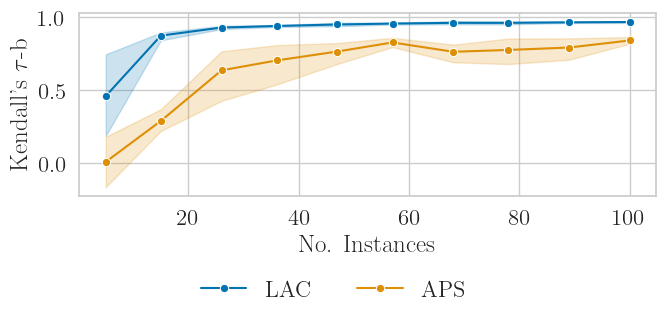

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 3)

df = df[["aps", "lac", "rand_aps", "num_inst"]]

fig, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel(r"Kendall's $\tau$-b")
ax.set_xlabel(r"No. Instances")
# ax.set_ylim([0.0,1])
sns.lineplot(data=df, x="num_inst", y="lac", ax = ax, marker="o",label="LAC", legend=False)
sns.lineplot(data=df, x="num_inst", y="aps", ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(data=df, x="num_inst", y="rand_aps", ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(x=num_instances_to_check, y=taus["rand_aps"], ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(x=num_instances_to_check, y=taus["own_rand_aps"], ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(x=num_instances_to_check, y=tau_corrs_own_aps, ax = ax, marker="o",label="Reconstructed APS", linestyle="--", legend=False)
# sns.lineplot(x=num_instances_to_check, y=tau_corrs_SAPS, ax = ax, marker="o", label="SAPS", legend=False)
lgd = fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.08), frameon=False)

fig.tight_layout() 
plt.savefig("replicating.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])

In [12]:
df.to_csv("replicating_ncs.csv")

In [8]:
from itertools import product
for run, score, size in product(range(0,5), ["lac", "aps"], range(0,10)):
    skills = skills_overall[run][score][size].detach().cpu().numpy()
    conformities = conformities_overall[run][score][size]
    print(kendalltau(skills.round(7), conformities.round(7)))

    import numpy as np
    from scipy.stats import kendalltau

    # Example data
    data1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    data2 = np.array([1, 3, 2, 4, 6, 5, 8, 7, 10, 9])

    # Rank the data
    ranked_data1 = np.argsort(np.argsort(data1))
    ranked_data2 = np.argsort(np.argsort(data2))

    # Select the top 80% of the ranked entries
    top_80_percent_index = int(0.8 * len(data1))
    top_ranked_data1 = ranked_data1[:top_80_percent_index]
    top_ranked_data2 = ranked_data2[:top_80_percent_index]

    # Compute Kendall Tau for the top 80% ranked entries
    tau, p_value = kendalltau(top_ranked_data1, top_ranked_data2)

    print(f"Kendall Tau: {tau}, p-value: {p_value}")



SignificanceResult(statistic=0.6266666666666668, pvalue=2.5087010784337538e-20)
Kendall Tau: 0.7857142857142856, p-value: 0.005505952380952381
SignificanceResult(statistic=0.882828282828283, pvalue=1.0137442672559246e-38)
Kendall Tau: 0.7857142857142856, p-value: 0.005505952380952381
SignificanceResult(statistic=0.9179797979797981, pvalue=1.004594783941848e-41)
Kendall Tau: 0.7857142857142856, p-value: 0.005505952380952381
SignificanceResult(statistic=0.9523232323232325, pvalue=9.01733598889199e-45)
Kendall Tau: 0.7857142857142856, p-value: 0.005505952380952381
SignificanceResult(statistic=0.9636363636363638, pvalue=8.455454427329116e-46)
Kendall Tau: 0.7857142857142856, p-value: 0.005505952380952381
SignificanceResult(statistic=0.9616161616161617, pvalue=1.2929434140736449e-45)
Kendall Tau: 0.7857142857142856, p-value: 0.005505952380952381
SignificanceResult(statistic=0.9781818181818184, pvalue=3.8710978185541377e-47)
Kendall Tau: 0.7857142857142856, p-value: 0.005505952380952381
Sign

In [9]:
import pickle
with open('skills.pkl', 'wb') as file:
    pickled_skills = pickle.dumps(skills_overall)
with open('conformities.pkl', 'wb') as file:
    pickled_conformities = pickle.dumps(conformities_overall)
with open('num_instances.pkl', 'wb') as file:
    pickled_num_instances = pickle.dumps(num_instances_to_check)